
=== BSSID Coverage Check ===

❌ BSSID ec:01:d5:27:1d:00 is missing 7 points:
  - Missing: (x=0, y=0)
  - Missing: (x=2, y=0)
  - Missing: (x=4, y=0)
  - Missing: (x=4, y=1)
  - Missing: (x=5, y=0)
  - Missing: (x=5, y=1)
  - Missing: (x=5, y=2)

❌ BSSID ec:01:d5:28:fa:c0 is missing 13 points:
  - Missing: (x=0, y=2)
  - Missing: (x=0, y=3)
  - Missing: (x=0, y=4)
  - Missing: (x=0, y=5)
  - Missing: (x=1, y=0)
  - Missing: (x=1, y=2)
  - Missing: (x=1, y=3)
  - Missing: (x=1, y=4)
  - Missing: (x=1, y=5)
  - Missing: (x=2, y=4)
  - Missing: (x=2, y=5)
  - Missing: (x=3, y=5)
  - Missing: (x=4, y=5)

❌ BSSID ec:01:d5:2b:5f:e0 is missing 4 points:
  - Missing: (x=4, y=4)
  - Missing: (x=4, y=5)
  - Missing: (x=5, y=4)
  - Missing: (x=5, y=5)


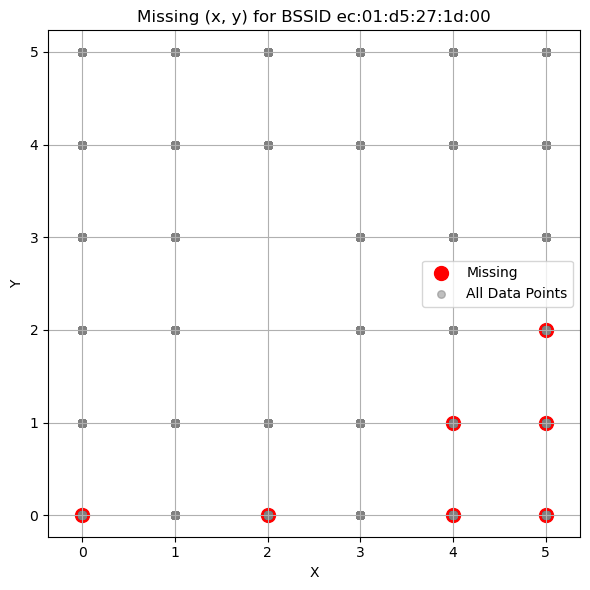

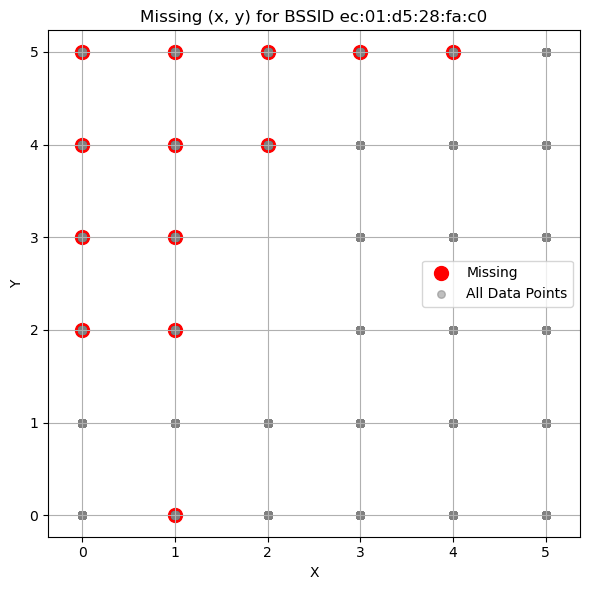

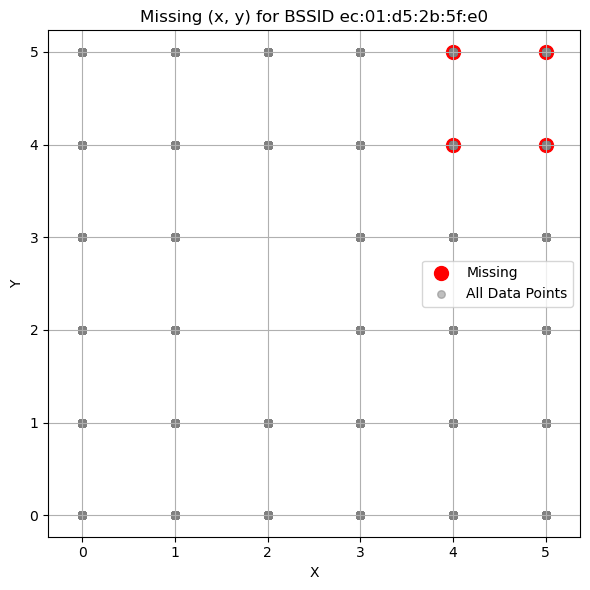

In [6]:
import matplotlib.pyplot as plt
from pymongo import MongoClient
import pandas as pd

# === Configuration ===
triangle_shape_filter = "reto_grande"
ssid_filter = "fun_network"
placeholder_rssi = -100
merged_collection_name = "wifi_data_indoor_global"

# Connect to MongoDB
client = MongoClient("mongodb://localhost:28910/")
db = client["wifi_data_db_indoor"]
collection = db[merged_collection_name]

# === Step 1: Load all matching documents and parse ===
all_data = []

cursor = collection.find({"metadata.triangle_shape": triangle_shape_filter})

for doc in cursor:
    x = doc["metadata"].get("x")
    y = doc["metadata"].get("y")
    timestamp = doc.get("timestamp")

    for entry in doc.get("data", []):
        if entry.get("SSID") == ssid_filter:
            all_data.append({
                "x": x,
                "y": y,
                "RSSI": entry.get("RSSI", placeholder_rssi),
                "BSSID": entry.get("BSSID"),
                "timestamp": timestamp
            })

df = pd.DataFrame(all_data)

# === Step 2: Get complete set of (x, y) positions ===
all_positions = set(tuple(row) for row in df[["x", "y"]].drop_duplicates().values)

# === Step 3: Check each BSSID for missing (x, y) points ===
bssid_groups = df.groupby("BSSID")

print("\n=== BSSID Coverage Check ===")
missing_summary = {}

for bssid, group in bssid_groups:
    positions = set(tuple(row) for row in group[["x", "y"]].drop_duplicates().values)
    missing = sorted(all_positions - positions)
    if missing:
        print(f"\n❌ BSSID {bssid} is missing {len(missing)} points:")
        for pos in missing:
            print(f"  - Missing: (x={pos[0]}, y={pos[1]})")
        missing_summary[bssid] = missing
    else:
        print(f"\n✅ BSSID {bssid} has full coverage.")

# === Step 4: Optional visualization of missing points per BSSID ===
for bssid, missing_points in missing_summary.items():
    xs, ys = zip(*missing_points)
    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, color="red", s=100, label="Missing")
    plt.scatter(df["x"], df["y"], color="gray", s=30, alpha=0.5, label="All Data Points")
    plt.title(f"Missing (x, y) for BSSID {bssid}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


In [9]:
from pymongo import MongoClient

# --- Configuration ---
DB_NAME = "wifi_data_db_indoor"
COLLECTION_NAME = "wifi_data_indoor_global"
SSID_FILTER = "fun_network"

# --- Connect to MongoDB ---
client = MongoClient("mongodb://localhost:28910/")
db = client[DB_NAME]
collection = db[COLLECTION_NAME]

# --- Aggregation to get unique BSSIDs for the SSID ---
bssid_cursor = collection.aggregate([
    {"$unwind": "$data"},
    {"$match": {"data.SSID": SSID_FILTER}},
    {"$group": {"_id": "$data.BSSID"}},
    {"$sort": {"_id": 1}}
])

# --- Collect and print BSSIDs ---
bssids = [doc["_id"] for doc in bssid_cursor]

print(f"✅ Found {len(bssids)} BSSIDs for SSID '{SSID_FILTER}':\n")
for bssid in bssids:
    print(f" - {bssid}")


✅ Found 3 BSSIDs for SSID 'fun_network':

 - ec:01:d5:27:1d:00
 - ec:01:d5:28:fa:c0
 - ec:01:d5:2b:5f:e0
